# Исследование рынка компьютерных игр

Объект анализа - исторические данные о продажах игр, выпущенных до 2016 года, оценки пользователей и экспертов, жанры и платформы по регионам: Северная Америка, Европа, Япония, остальной мир. 
 
Цель исследования - проанализировать критерии влияющие на успешность той или иной игры. На результатах исследования будет основываться дальнейшая стратегия рекламной компании на 2017 год.  

План работы:

    1 - Загрузка и обзор данных 
    2 - Предобработка данных
    3 - Исследовательский анализ
    4 - Ставнительный анализ по регионам
    5 - Проверка гипотез
    6 - Вывод

### Загрузка и обзор данных

In [3]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [4]:
raw_data = pd.read_csv("/games.csv")
raw_data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


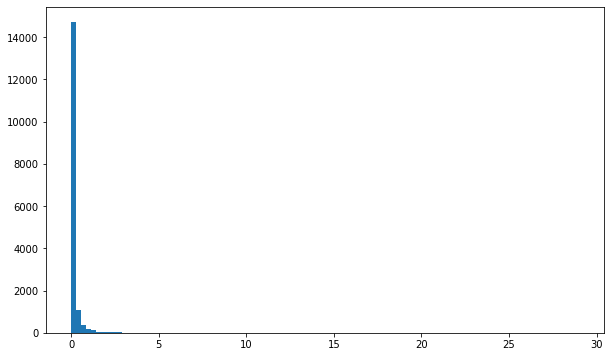

In [5]:
plt.figure(num=None, figsize=(10, 6))
plt.hist(raw_data['EU_sales'], bins = 100);


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [7]:
# Оценим объем пропущенных значений в данных

(100. * raw_data.loc[:, raw_data.isna().any()].isna().sum()/raw_data.shape[0]).round(2).astype(str) + '%'

Name                0.01%
Year_of_Release     1.61%
Genre               0.01%
Critic_Score       51.32%
User_Score         40.09%
Rating             40.48%
dtype: object

In [8]:
raw_data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [9]:
raw_data.duplicated().sum()

0

#### Вывод:

Таблица содержит информацию о 16715 играх для различных игровых платформ. Год выпуска варьируется с 1980 по 2016. 
В представленных данных большое количество пропущеннных значений, преимущественно в части рейтингов (Critic_Score, User_Score, Rating). Полных дубликатов нет.

В данных по продажам около половины наблюдений имеют нулевые значения. Чтобы получить общую статистическую информацию по столбцам User_Score, Rating, нужно преобразовать тип данных в числовой. В некоторых других столбцах также нужно изменить тип данных.

### Предобработка данных

In [10]:
df = raw_data.copy()

In [11]:
# Приведем назнания столбцов к общему виду

df.columns = [x.lower() for x in df.columns]

#### Обработка пропусков

Рассмотрим столбцы в которых были обнаружены пропущенные данные: Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating

In [12]:
# Столбец "Name"

df[df['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В данных об играх с пропущенными названиями отсутствует другая важная информация. Т.к. пропущенных значений около 0,01%, можно эти строки удалить.

In [13]:
df = df[~df['name'].isnull()]

In [14]:
# Столбец Year_of_Release

df[df['year_of_release'].isnull()].head(8)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+


Пропущенные значения встречаются у игр на разных платформах, разных жанров, уровнях продаж и рейтингов. Попробуем заменить NaN на какое-то характерное значение

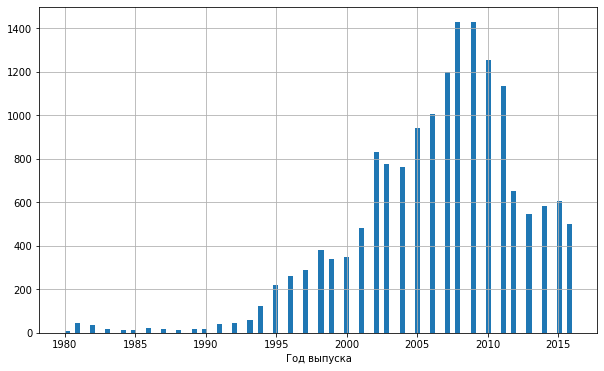

In [15]:
# Рассмотрим распределение данных по году выпуска игр

plt.figure(num=None, figsize=(10, 6))
plt.hist(df['year_of_release'], bins = 100)
plt.xlabel("Год выпуска")
plt.grid(True)
plt.show()

Распределение сдвинуто влево. Подходящим значением для замены пропущенных значений будет медиана по типу игровой платформы, т.к. для каждой платформы характерен свой период активного выпуска игр.

In [16]:
platforms, platform_year = ([],[])

for platform in list(df['platform'].unique()):
    platforms.append(platform)
    median_year = df[df['platform'] == platform]['year_of_release'].median(skipna = True)
    df.loc[df['platform'] == platform,'year_of_release'] = df[df['platform'] == platform]['year_of_release'].fillna(median_year)
    platform_year.append(median_year)
    
platform_year_median = pd.DataFrame({'platform' : platforms, 
                            'median year' : platform_year})
platform_year_median = platform_year_median.sort_values(by = 'median year').reset_index(drop = True)
platform_year_median.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
platform,2600,NES,GG,GEN,SCD,SNES,NG,3DO,TG16,SAT,PCFX,GB,PS,N64,WS,DC,GC,GBA,XB,PS2,DS,PSP,Wii,PC,X360,PS3,WiiU,3DS,PSV,PS4,XOne
median year,1982,1986.5,1992,1993,1994,1994,1994.5,1995,1995,1996,1996,1997,1998,1999,2000,2000,2003,2003,2004,2005,2008,2009,2009,2010,2010,2011,2013,2013,2014,2015,2015


In [17]:
# Столбец "Genre"

df[df['genre'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


В столбце "Genre" значения были пропущены в тех же двух строках, где были NaN в названии.

Наибольшее количество пропущенных значений в столбцах с оценками: Critic_Score, User_Score, Rating. Удалить эти значения нельзя, это приведет к потере половины данных. Поставив на их место средние или медиану по группам (года выпуска, платформы или жанра) мы рискуем существенно изменить реальное распределение данных. Заменим NaN в этих столбцах на -1 чтобы можно было в дальнейшем преобразовать форматы в этих столбцах и при необходимости отсеить отрицательные значения.


In [18]:
for column in ['critic_score', 'user_score', 'rating']:
    df[column] = df[column].fillna(-1)

В столбце "user_score" тип данных - object. Посмотрим какие значения есть в этом столбце

In [19]:
df['user_score'].unique()

array(['8', -1, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Помимо числовых значений встречается значение "tbd", что означает to be determined. По сути, это тот же NaN. Заменим все tbd на -1

In [20]:
df['user_score'] = df['user_score'].replace('tbd', -1)

Рассмотрим столбец "rating"

In [21]:
df['rating'].unique()

array(['E', -1, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [22]:
# В столбце "rating" также есть значение RP (Rating Pending), означающее отсутствие значения на дату формирования базы.

df['rating'] = df['rating'].replace('RP', -1)

Пропуски в столбцах "genre" и "name" возникли скорее всего из-за потери информации на момент создания датасета.
<br>NaN-значения в столбце "year_of_release" вероятно связаны с ошибкой при выгрузке таблицы.
<br>В столбцах 'critic_score', 'user_score' и 'rating' значения могут отсутствовать по причине того, что не все игры попадают в рейтинги и оцениваются экспертами и пользователями или были потеряны.

#### Изменение типов данных

In [23]:
# Функция подсчета памяти, используемой для хнанения данных

def mem_usage(data):
    usage_b = data.memory_usage(deep=True).sum()
    usage_mb = usage_b / 1024 ** 2 
    return usage_mb.round(3)

In [24]:
# Функция замены формата данных и оптимизации числовых подформатов

def dtype_optim(data):
        
    obj_columns = []
    data_int = data.drop(axis = 1, columns = data.columns)
    converted_int = data.drop(axis = 1, columns = data.columns) 
    data_float = data.drop(axis = 1, columns = data.columns)
    converted_float = data.drop(axis = 1, columns = data.columns) 
    data_obj = data.drop(axis = 1, columns = data.columns)
    converted_obj = data.drop(axis = 1, columns = data.columns) 

    
# Преобразуем столбцы типа 'object' в числовой формат 
    for column in data.columns:
        if data[column].dtype == 'object':
            obj_columns.append(column)
            data_obj = pd.concat([data_obj, data[column]], axis = 1)
            try:
                data[column] = pd.to_numeric(data[column])
                converted_obj = pd.concat([converted_obj, data[column]], axis = 1)
            except:
                print('Не удалось преобразовать формат object в столбце ', column)

# Преобразуем столбцы типа 'float'
        if data[column].dtype == 'float64':
            data_float = pd.concat([data_float, data[column]], axis = 1)
            try:
                data[column] = pd.to_numeric(data[column], downcast='signed')
                converted_float = pd.concat([converted_float, data[column]], axis = 1)
            except:
                print('Не удалось преобразовать формат float в столбце ', column)

# Преобразуем столбцы типа 'int'                
        if data[column].dtype == 'int64':           
            data_int = pd.concat([data_int, data[column]], axis = 1)
            try:
                data[column] = pd.to_numeric(data[column], downcast='signed')
                converted_int = pd.concat([converted_int, data[column]], axis = 1)
            except:
                print('Не удалось преобразовать формат int в столбце ', column)
        else: 
            pass
    
    tot_mem_before = (mem_usage(data_int) + mem_usage(data_float) + mem_usage(data_obj)).round(3)
    tot_mem_after = (mem_usage(converted_int) + mem_usage(converted_float) + mem_usage(converted_obj)).round(3)
    reduced_int = (100*(1-mem_usage(converted_int)/ mem_usage(data_int))).round(3)
    reduced_float = (100*(1-mem_usage(converted_float)/ mem_usage(data_float))).round(3)
    reduced_total = (100*(1-tot_mem_after/tot_mem_before)).round(3)
    reduced_obj = (100*(1-mem_usage(converted_obj)/ mem_usage(data_obj))).round(3)

# Строим итоговую таблицу экономленной памяти
    mem_optimized = pd.DataFrame({'dtype' : ['int', 'float', 'object', 'total'], 
                                 'before, MB' : [mem_usage(data_int), mem_usage(data_float), mem_usage(data_obj), tot_mem_before], 
                                 'after, MB' : [mem_usage(converted_int), mem_usage(converted_float), mem_usage(converted_obj), tot_mem_after],
                                 'reduced, %' : [reduced_int, reduced_float, reduced_obj, reduced_total]})
    display(mem_optimized)
    display(data.info())

In [25]:
dtype_optim(df)

Не удалось преобразовать формат object в столбце  name
Не удалось преобразовать формат object в столбце  platform
Не удалось преобразовать формат object в столбце  genre
Не удалось преобразовать формат object в столбце  rating


,dtype,"before, MB","after, MB","reduced, %"
0,int,0.128,0.128,0.000
1,float,1.020,0.813,20.294
2,object,4.927,0.255,94.824
3,total,6.075,1.196,80.313


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int16  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  int8   
 9   user_score       16713 non-null  float64
 10  rating           16713 non-null  object 
dtypes: float64(5), int16(1), int8(1), object(4)
memory usage: 1.3+ MB


None

В результате оптимизации форматов, удалось привести данные к нужному типу и снизить использование памяти на 80%.

Для дальшейшего анализа нам понадобятся суммарные значения продаж во всем мире.

In [26]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

#### Вывод

В результате предобработки данных удалось очистить таблицы от пропущенных значений. Также получилось привести к нужному типу данные с годом выпуска игр и оценками критиков и пользователей. В итоге оптимизации подформатов объем используемой памяти снизился примерно на 80%.
<br>Расчитаны суммарные продажи игр по всем странам.

### Исследовательский анализ

#### Временной анализ

Расмотрим еще раз распределние игр по году выпуска. Для наглядности построим boxplot и гистограмму распределения с основными статистическими уровнями

In [27]:
# Напишем функцию для автоматизации анализа

def analyze_param(data, label, bins = 600):
    
    mean = np.round(np.mean(data), 2)
    median = np.round(np.median(data), 2)
    variance = np.round(np.var(data), 2)
    standart_deviation = np.round(np.std(data), 2)
    min_value = np.round(data.min(), 2)
    max_value = np.round(data.max(), 2)
    Q0_05 = np.round(data.quantile(0.05), 2)
    Q1 = np.round(data.quantile(0.25), 2)
    Q3 = np.round(data.quantile(0.75), 2)
    Q0_95 = np.round(data.quantile(0.95), 2)
    iqr = np.round(Q3 - Q1, 2) # Interquartile range
    skew = data.skew()
    kurtosis = data.kurtosis()
    
    fig, axs = plt.subplots(2, 1, figsize = (12,12))

    axs[0].set(xlabel = label)
    axs[0].boxplot(data,
                   notch=True, 
                   sym="o", 
                   vert=False,
                   widths = 0.1, 
                   patch_artist = True)
    axs[0].tick_params(axis = 'both', 
                       which = 'major', 
                       direction = 'inout', 
                       pad = 10)
                       
    axs[1].set(xlabel = label)                  
    axs[1].hist(data, bins)

    plt.suptitle(label, y = 0.94)
    fig.subplots_adjust(hspace=0.3)
    plt.axvline(x=data.mean(),
                linewidth=2, 
                color='g', 
                linestyle='--',
                label = 'Среднее')
    plt.axvline(x=data.median(),
                linewidth=2, 
                color='red', 
                linestyle='--',
                label = 'Медиана')
    plt.axvline(x=data.quantile(.05),
                linewidth=2, 
                color='y', 
                linestyle='--',
                label = '5й квантиль')
    plt.axvline(x=data.quantile(.95),
                linewidth=2, 
                color='y', 
                linestyle='--',
                label = '95й квантиль')
    leg = axs[1].legend();
    plt.grid(True)
    plt.show()
    
    print('Min: {:.2f}'.format(min_value))
    print('Mean: {:.2f}'.format(mean))
    print('Max: {:.2f}'.format(max_value))
    print('Variance: {:.2f}'.format(variance))
    print('Standart deviation: {:.2f}'.format(standart_deviation))
    print('5st percentile: {:.2f}'.format(Q0_05)) 
    print('25th percentile: {:.2f}'.format(Q1))
    print('Median: {:.2f}'.format(median))
    print('75th percentile: {:.2f}'.format(Q3))
    print('95th percentile: {:.2f}'.format(Q0_95))
    print('Interquartile range (IQR): {:.2f}'.format(iqr))
    print('Skew: {:.2f}'.format(skew))
    print('Kurtosis: {:.2f}'.format(kurtosis))

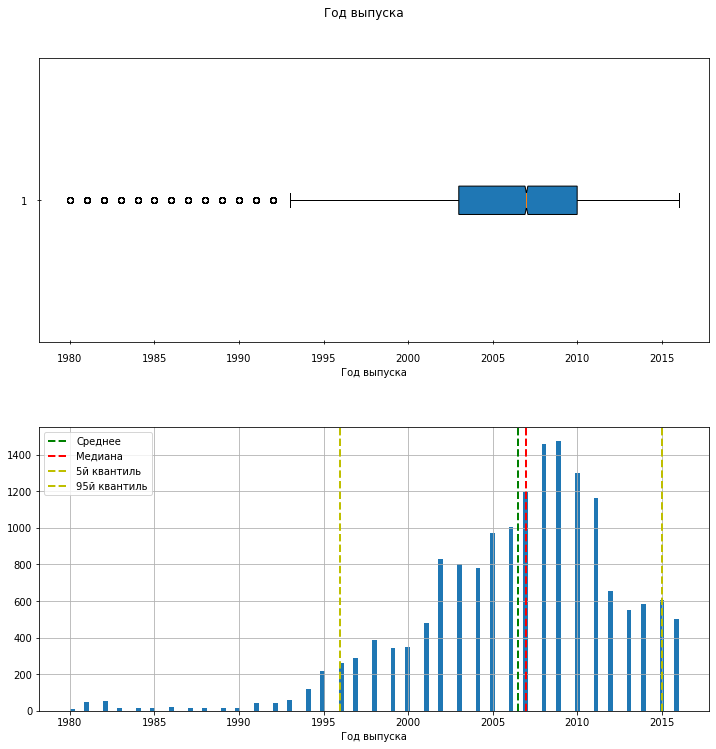

Min: 1980.00
Mean: 2006.47
Max: 2016.00
Variance: 34.76
Standart deviation: 5.90
5st percentile: 1996.00
25th percentile: 2003.00
Median: 2007.00
75th percentile: 2010.00
95th percentile: 2015.00
Interquartile range (IQR): 7.00
Skew: -1.02
Kurtosis: 1.93


In [28]:
analyze_param(df['year_of_release'], 
              label = 'Год выпуска', 
              bins = int(np.sqrt(len(df['year_of_release']))))

Значения года выпуска игр распределены преимущетвенно в диапазоне 1996 - 2015 г. со средним значением 2006.47 г. и медианным 2007 г.. Распределение смещено влево. Стандартное отклонение равно 5.9 лет.
<br> Игры, выпущенные до 1993 года можно считать выбросами, но как мы видели при расчете медианного значения даты выпуска, некоторые платформы были популярны только с 1982 по 1993 г.

Рассмотрим как изменялось число продаж игр, выходивших на разных платформах. Для упорядочивания игровых платформ по времени используем таблицу platform_year_median, которую мы создали при расчете медианного года выпуска.

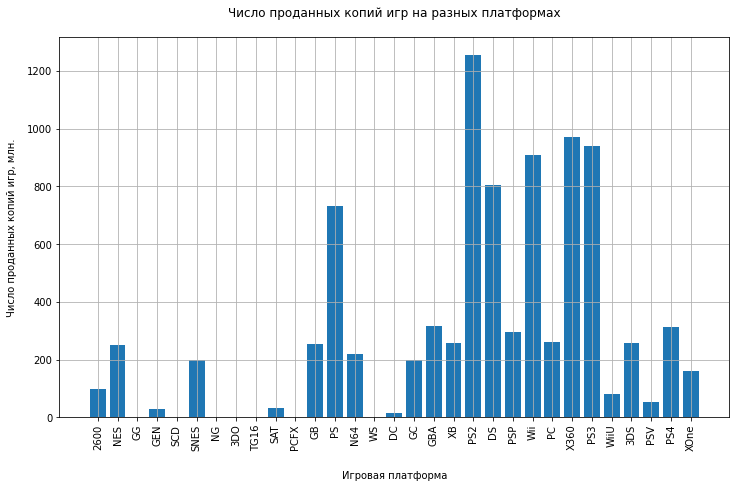

In [29]:
platform_group_sales = df.groupby('platform')['total_sales'].sum()
platform_sales = platform_year_median.merge(platform_group_sales, on = ['platform'])

plt.figure(num=None, figsize=(12, 7))
plt.bar(platform_sales['platform'], platform_sales['total_sales'])

plt.xticks(rotation='vertical')
plt.title('Число проданных копий игр на разных платформах', pad = 20)
plt.xlabel('Игровая платформа', labelpad = 20)
plt.ylabel('Число проданных копий игр, млн.', labelpad = 10)
plt.grid(True)

plt.show()

Наибольшие значения продаж показывают платформы PS2, Wii, X360 и PS3. Посмотрим как распределены суммарные продажи игр на этих платформах по годам.

In [30]:
# Функция расчета и построения зависимости продаж от времени релиза

def year_sales(data, platform_name_list):
    
    platform_sales = pd.DataFrame()
    platform_sales_table = pd.DataFrame()
    platform_sales_table['year_of_release'] = pd.Series(np.arange(2016,2017,1))
    
#Считаем продажи по годам по всем платформам
    for platform_name in platform_name_list:
        platform_sales = data.query('platform == @platform_name').groupby('year_of_release')['total_sales'].sum().reset_index()
        platform_sales = platform_sales.rename(columns={'year_of_release': 'year_of_release', 'total_sales': platform_name})
        platform_sales_table = platform_sales_table.merge(platform_sales , on = ['year_of_release'], how='outer').reset_index(drop= True) 
        
    platform_sales_table.sort_values(by = ['year_of_release'], inplace = True)
    
    fig, ax = plt.subplots(figsize = (14,8)) 
    ax.set_title('Число продаж игр на разных платформах по годам выпуска', pad = 20)
    ax.set(xlabel = "Год")
    
# Строим графики    
    for platform_name in platform_name_list:
        plt.plot(platform_sales_table['year_of_release'], platform_sales_table[platform_name], linewidth=3, label = platform_name)
    
    plt.xticks(np.arange(platform_sales_table['year_of_release'].min(), platform_sales_table['year_of_release'].max()+1, step=1))
    plt.xlabel('Год', labelpad = 20)
    plt.ylabel('Число проданных копий игр, млн.', labelpad = 10)
    plt.grid(True)
    leg = plt.legend()
    plt.show()


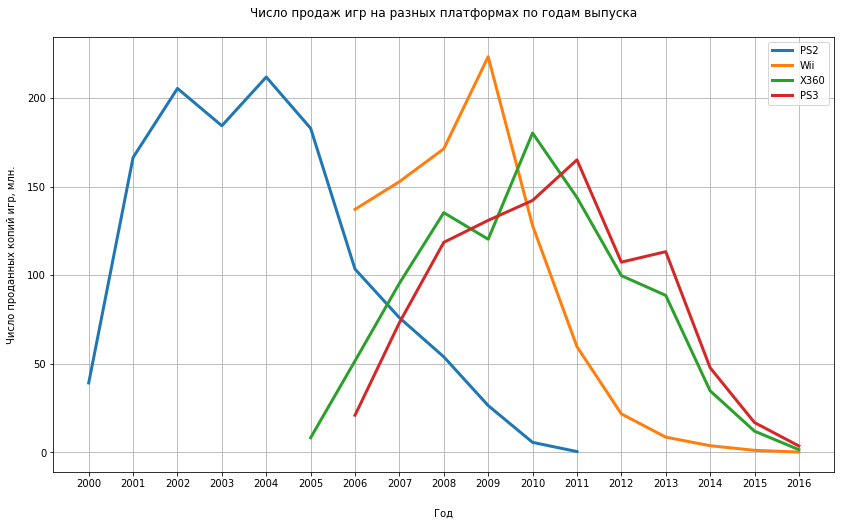

In [31]:
platform_name_list = ['PS2', 'Wii', 'X360', 'PS3']
year_sales(df, platform_name_list)

Продажи игр для всех платформ ведут себя похожим образом: после выпуска новой игровой приставки первые 3-5 лет количество проданных игр растет, достигает максимума и затем снижается практически до нуля за следующие 6-7 лет.


<div class="alert alert-block alert-info">
    
Три из четырех платформ показывают устойчивые продажи в первые 5 лет. Ограничим период анализа 2011 - 2016 годами.
</div>

In [32]:
df2 = df.query('year_of_release >= 2011')

#### Сравнение игровых платформ

Посмотрим какие платформы были популярны в период с 2011 по 2016 год.

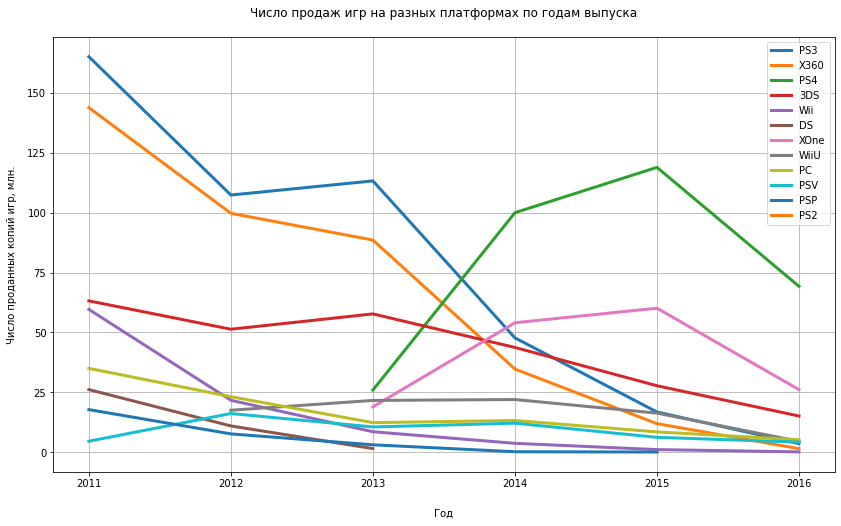

In [33]:
platform_name_list = list(df2['platform'].unique())
year_sales(df2, platform_name_list)

Большинство платформ показывает нисходящую динамику продаж игр. Все новые игровые платформы PS4, XOne, 3DSб  и WiiU, первые игры на которых появились втечение 5 последних лет наблюдений также показывают значительное падение после 2015 года, но это, возможно, объясняется неполными данными по продажам за последний год. 

Наиболее перспективными платформами на 2017 год выглядят PS4, XOne. 

Рассмотрим статистику глобальных продаж по платформам за последние 7 лет. 

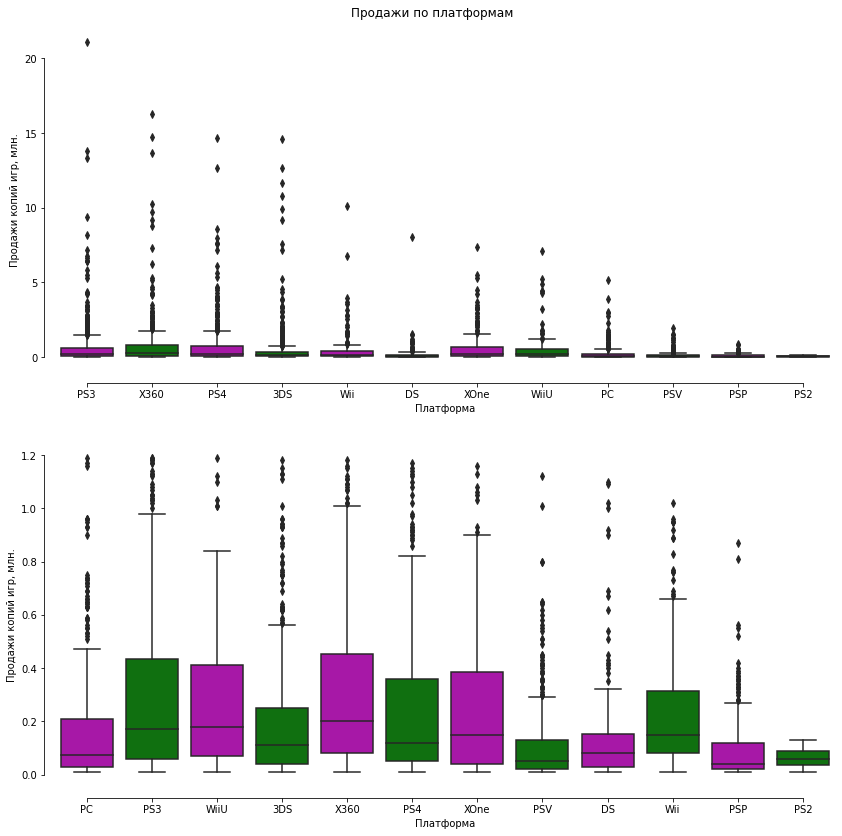

In [34]:
fig, axs = plt.subplots(2, 1, figsize = (14,14))
plt.suptitle('Продажи по платформам', y = 0.9)
axs[0].set(xlabel = 'Платформа', ylabel = 'Продажи копий игр, млн.')
sns.boxplot(x="platform", y="total_sales",
                palette=["m", "g"],
               data=df2, 
               ax=axs[0])
axs[0].set_xlabel('Платформа')
axs[0].set_ylabel('Продажи копий игр, млн.')
                  

axs[1].set(xlabel = 'Платформа', ylabel = 'Продажи копий игр, млн.')                 
sns.boxplot(x="platform", y="total_sales", palette=["m", "g"], data=df2.query('total_sales <= 1.2'), ax=axs[1])
axs[1].set_xlabel('Платформа')
axs[1].set_ylabel('Продажи копий игр, млн.')
    
sns.despine(offset=10, trim=True)

Основная часть игр на всех платформах показывает до 2 млн. проданных копий игры. Лишь для трех самых популярных игровых приставок за этот период были игры с более чем 20 млн продажами. Эти значения, которые со статистической точки зрения можно считать выбросами, являются основным объектом нашего иследования.

Изучим как влияют отзывы пользователей и критиков на продажи игр внутри самых актуальных платформ на 2017 год - PS4 и XOne.  

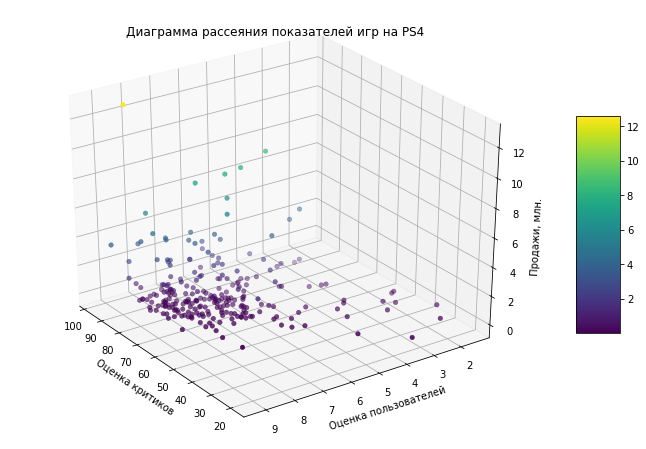

In [35]:
df_3d = df2.query('platform in ["PS4", "XOne"] & critic_score >= 0 & user_score >= 0')[['critic_score', 'user_score', 'total_sales', 'platform']]
df_3d_PS2 = df2.query('platform == "PS2"& critic_score >= 0 & user_score >= 0')[['critic_score', 'user_score', 'total_sales']]
df_3d_PS4 = df2.query('platform == "PS4" & critic_score >= 0 & user_score >= 0')[['critic_score', 'user_score', 'total_sales']]
df_3d_XOne = df2.query('platform == "XOne" & critic_score >= 0 & user_score >= 0')[['critic_score', 'user_score', 'total_sales']]

fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
surf = ax.scatter(df_3d_PS4['critic_score'], df_3d_PS4['user_score'], df_3d_PS4['total_sales'],  c=df_3d_PS4['total_sales'], cmap='viridis', linewidth=0.5)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 145)
ax.set_title('Диаграмма рассеяния показателей игр на PS4')
ax.set_xlabel('Оценка критиков')
ax.set_ylabel('Оценка пользователей')
ax.set_zlabel('Продажи, млн.')
plt.show()

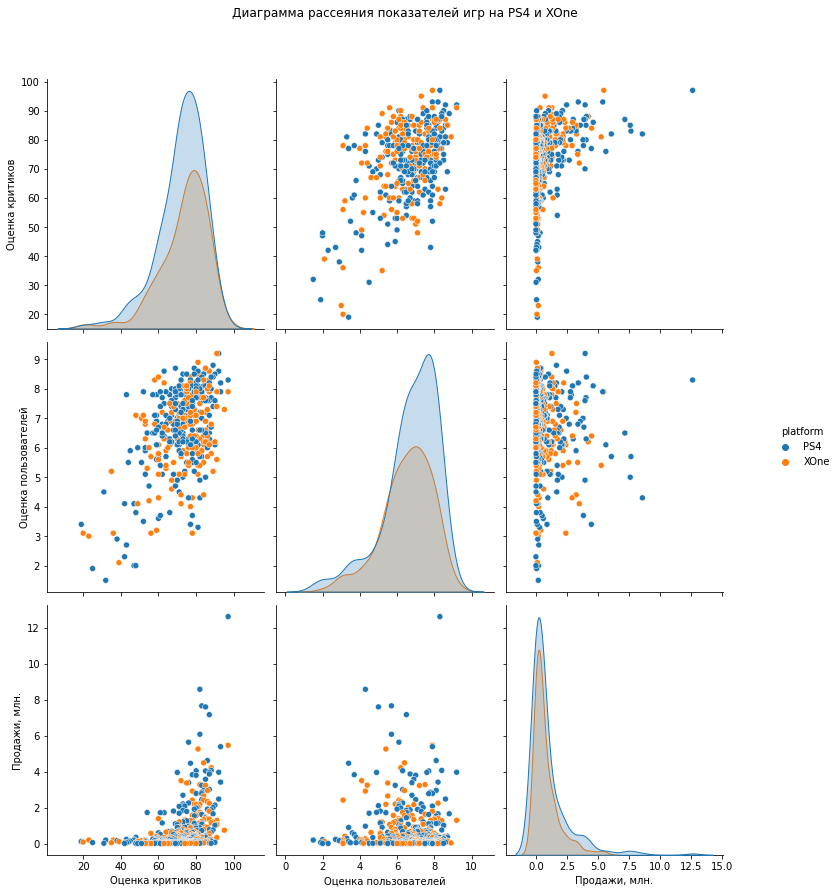

In [36]:
labels = ['Оценка критиков', 'Оценка пользователей', 'Продажи, млн.']
g = sns.pairplot(df_3d, hue="platform", diag_kind="kde")
g.fig.suptitle("Диаграмма рассеяния показателей игр на PS4 и XOne", y=1.06)
g.fig.set_size_inches(12,12)
for i in range(3):
    g.axes[i][0].set_ylabel(labels[i])
    g.axes[2][i].set_xlabel(labels[i])

plt.show()

Диаграммы рассеяния для PS4 и XOne выглядят очень похоже. Посчитаем корелляцию продаж и отзывов на игры.

In [37]:
sales_corr = pd.DataFrame({'PS4':df_3d_PS4.corr()['total_sales'],
                           'XOne':df_3d_XOne.corr()['total_sales']})
print('Коэффициенты корелляции между отзывами и количеством продаж :')
sales_corr

Коэффициенты корелляции между отзывами и количеством продаж :


,PS4,XOne
critic_score,0.405895,0.410422
user_score,-0.033625,-0.094003
total_sales,1.000000,1.000000


Как видно из таблицы, существует достаточно сильная корелляция между оценками критиков и количеством проданных копий игр.
С оценками пользователей продажи наоборот, практически не связаны. Примечательно, что в случае XOne обратная корелляция сильнее, чем у PS4, но ее значение все равно слишком мало.

Рассмотрим корелляцию продаж и оценок по другим платформам 

In [38]:
df_reviews = df2.query('critic_score >= 0 & user_score >= 0')[['critic_score', 'user_score', 'total_sales', 'platform']]
sales_corr_tot = pd.DataFrame()
sales_platform_corr = pd.DataFrame()
for platform_name in list(df_reviews['platform'].unique()):
    sales_platform_corr = pd.DataFrame({platform_name : df_reviews[df_reviews['platform'] == platform_name].corr()['total_sales']})
    sales_corr_tot  = pd.concat([sales_corr_tot, sales_platform_corr], axis = 1)

sales_corr_tot 

,PS3,X360,3DS,PS4,Wii,WiiU,XOne,PC,PSV,DS,PSP
critic_score,0.375743,0.390397,0.339824,0.405895,0.25492,0.350882,0.410422,0.313526,0.131349,0.218903,0.426256
user_score,0.025473,0.024111,0.233403,-0.033625,0.14649,0.391848,-0.094003,-0.058215,0.038374,0.035187,0.128385
total_sales,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


У некоторых менее популярных платформ, таких как 3DS, DS и WiiU мы видим небольшую корелляцию количества проданных копий и оценки пользователей. В то же время, оценка критиков почти для всех платформ показывает сопоставимые коэффициенты корелляции с продажами.

#### Анализ жанров

Рассмотрим общее распределение игр по жанрам. 

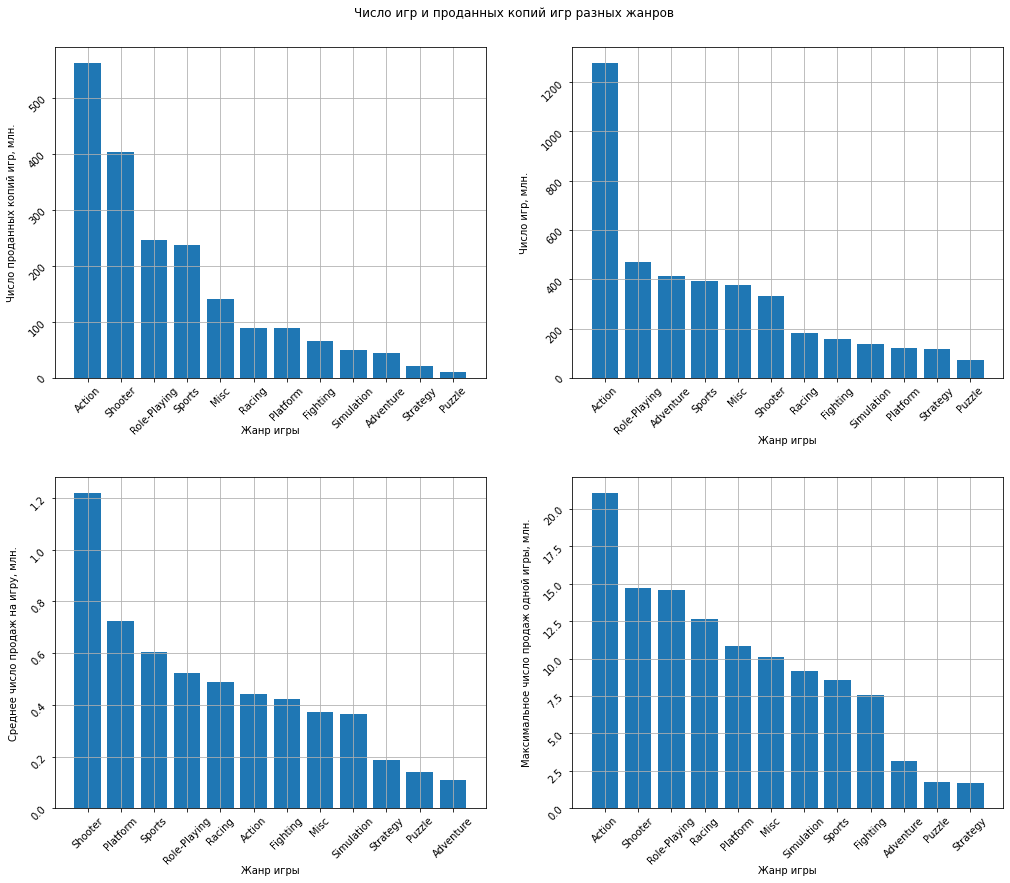

In [39]:
df_genres = df2.pivot_table(index = 'genre', values = 'total_sales', aggfunc = ['sum','count','mean', 'max']).reset_index()
df_genres.columns = ['genre', 'sum_sales', 'amount', 'average_sales', 'top_sales']
df_genres.sort_values('sum_sales', ascending = False, inplace = True)
d = {0:(0,0), 1:(0,1), 2:(1,0), 3:(1,1)}
fig, axs = plt.subplots(2, 2, figsize = (17,14))
for n, col in enumerate(['sum_sales', 'amount', 'average_sales', 'top_sales']):
    (i,j) = d[n]
    df_genres.sort_values(col, ascending = False, inplace = True)
    axs[i,j].bar(x = df_genres['genre'], height = df_genres[col])
    axs[i][j].tick_params(labelrotation=45)
    axs[i][j].grid(True)
    
axs[0][0].set_xlabel('Жанр игры', labelpad = -10)
axs[0][0].set_ylabel('Число проданных копий игр, млн.', labelpad = 10)

axs[0][1].set_xlabel('Жанр игры', labelpad = 0)
axs[0][1].set_ylabel('Число игр, млн.', labelpad = 10)

axs[1][0].set_xlabel('Жанр игры', labelpad = 0)
axs[1][0].set_ylabel('Среднее число продаж на игру, млн.', labelpad = 10)

axs[1][1].set_xlabel('Жанр игры', labelpad = 0)
axs[1][1].set_ylabel('Максимальное число продаж одной игры, млн.', labelpad = 10)


# plt.title('Число игр и проданных копий игр разных жанров', pad = 2)
plt.suptitle('Число игр и проданных копий игр разных жанров', y = 0.92)
fig.subplots_adjust(hspace=0.3)
plt.show()

По суммарному количеству проданных копий игр наибольшее число у жанра Action, также по другим графикам видно, что это связано скорее всего с большим количеством выпущенных игр, т.е с популярностью самого жанра, а не с популярностью отдельных игр. Самая продаваемая Action игра стоит на четвертом месте, а средние продажи - на шестом.
<br>К популярным жанрам можно также отнести Shooter и Sports.



При этом можно выделить группу жанров с самыми низкими показателями по всем параметрам. Это Puzzle, Strategy и Adventure.



#### Вывод

Из анализа даты выхода игр мы выяснили актуальный период для игровых платформ - 7 лет. Выявили наиболее перспективные платформы на 2017 год - PS4, XOne. Определили что оценки критиков существенно влияют на продажи игр, а оценки пользователей - нет.
<br>Наиболее перспективные жанры - Action, Shooter, Sport.

### Ставнительный анализ по регионам

Рассмотрим статистику проданных игр по регионам Северная Америка, Европа, Япония.

Создадим функию, которая составляет рейтинг лидеров продаж по различным параметрам игр.


In [40]:
def reg_5_top(data, param, region):

    values = region+'_sales'
    
    a = data[data[values] > 0]
    df_5_top = a.pivot_table(index = param, values = values, aggfunc = ['sum', 'count'])
    total_sales_share = float(df_5_top['sum'].sum())
    top_sum = df_5_top.nlargest(5,('sum',values))[('sum',values)].reset_index()
    top_sum['sales_share'] = (top_sum['sum']*100/total_sales_share).round(2)
    top_count = df_5_top.nlargest(5,('count',values))[('count',values)].reset_index()
    result = pd.concat((top_sum,top_count), axis = 1)
    result.columns = ['Топ-5 по числу копий', 'Продажи в '+region+', млн.', 'Доля продаж, %', 'Топ-5 по числу игр', 'Число игр в '+region]
    print()
    print('Топ-5 '+param+' по региону "'+region.upper()+'"')
    display(result)

In [41]:
# Составим рейтинги самых популярных платформ в разных регионах по числу проданных копий и числу выпущенных игр.

reg_5_top(df2, "platform", "na")
print()
reg_5_top(df2, "platform", "eu")
print()
reg_5_top(df2, "platform", "jp")


Топ-5 platform по региону "NA"


,Топ-5 по числу копий,"Продажи в na, млн.","Доля продаж, %",Топ-5 по числу игр,Число игр в na
0,X360,226.80,27.19,PS3,494
1,PS3,171.62,20.58,X360,440
2,PS4,108.74,13.04,PS4,294
3,XOne,93.12,11.16,3DS,266
4,3DS,83.49,10.01,XOne,227




Топ-5 platform по региону "EU"


,Топ-5 по числу копий,"Продажи в eu, млн.","Доля продаж, %",Топ-5 по числу игр,Число игр в eu
0,PS3,166.18,24.69,PS3,486
1,PS4,141.09,20.96,X360,421
2,X360,117.10,17.40,PC,370
3,3DS,61.48,9.13,PS4,290
4,PC,56.70,8.42,3DS,249




Топ-5 platform по региону "JP"


,Топ-5 по числу копий,"Продажи в jp, млн.","Доля продаж, %",Топ-5 по числу игр,Число игр в jp
0,3DS,100.67,40.83,PS3,453
1,PS3,50.17,20.35,PSV,366
2,PSP,24.04,9.75,3DS,360
3,PSV,21.91,8.89,PSP,298
4,PS4,15.96,6.47,PS4,223


В Северной Америке 27.2% продаж (226.80 млн.) c 2009 года приходился на игры для X360, а на втором месте стоит PS3 c 20.58% от всех продаж с 171.62 млн. проданных копий. При этом игр для этих платформ было выпущено 494 и 440 соответственно.

<br>В Европе первые местазанимают платформы PS3 и PS4. По доли рынка игры для PS3 составляют 24.69% от общего объема продаж, а игры под PS4 - 20.96%. Стоит отметить, что количество игр, продаваемых на территории Европы примерно такое же как в Америке, а вот число проданных копий заметно меньше. Это свидетельствует о том, что в Северной Америке значительно больше активных пользователей этих продуктов.

<br>Таблица лидеров продаж по платформам в Японии отличается от других регионов. На этом рынке нет приставок XOne и X360, но первое место по доле продаж занимает 3DS c 40.83%. Также много игр по прежнему выпускается для мобильной приставки PSP, которая не попадает в топ-5 в других регионах. Количество проданных копий игр еще меньше, чем в Европе - 100.67 млн. и 50.17 млн. у двух самых популярных платформ.

In [42]:
# Составим рейтинги самых популярных жанров в разных регионах по числу проданных копий и числу выпущенных игр.

reg_5_top(df2, "genre", "na")
print()
reg_5_top(df2, "genre", "eu")
print()
reg_5_top(df2, "genre", "jp")


Топ-5 genre по региону "NA"


,Топ-5 по числу копий,"Продажи в na, млн.","Доля продаж, %",Топ-5 по числу игр,Число игр в na
0,Action,232.44,27.87,Action,780
1,Shooter,194.64,23.34,Shooter,300
2,Sports,108.86,13.05,Sports,268
3,Role-Playing,83.89,10.06,Misc,237
4,Misc,70.93,8.50,Role-Playing,236




Топ-5 genre по региону "EU"


,Топ-5 по числу копий,"Продажи в eu, млн.","Доля продаж, %",Топ-5 по числу игр,Число игр в eu
0,Action,200.57,29.80,Action,833
1,Shooter,148.08,22.00,Shooter,292
2,Sports,88.83,13.20,Sports,287
3,Role-Playing,62.35,9.26,Role-Playing,234
4,Racing,41.06,6.10,Misc,212




Топ-5 genre по региону "JP"


,Топ-5 по числу копий,"Продажи в jp, млн.","Доля продаж, %",Топ-5 по числу игр,Число игр в jp
0,Role-Playing,80.03,32.46,Action,655
1,Action,64.26,26.06,Role-Playing,383
2,Misc,17.60,7.14,Adventure,283
3,Fighting,12.38,5.02,Misc,147
4,Platform,12.13,4.92,Shooter,132


По региону Северная Америка наибольшее число проданных копий приходится на игры в жанре Action - 27.87%. Вторым идет жанр Shooter c долей в 23.34% продаж. При этом количество игр в жанре Action почти в 2.5 раза больше, чем в жанре Shooter - 780 против 300. Также в этом регионе популярны жанры Sports, Misc и Role-Playing.

<br> Продажи игр в Европе по жанрам рапределены почти точно так же, как и в Америке. Значит в данном аспекте эти регионы можно рассматривать совместно.

<br> Япония, как и в распределении по платформам сильно отличается от остального мира. Тут на первом месте с 32.46% долей продаж находится жанр Role-Playing, а доля продаж игр в жанре Shooter мала и не попадает в топ.

Рассмотрим распределение продаж по категориям рейтинга ESRB в каждом регионе.

In [43]:
df2

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
29,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88,3.4,M,14.73
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,-1.0,-1,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1,-1.0,-1,14.60
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1,-1.0,-1,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,-1,-1.0,-1,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1,-1.0,-1,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1,-1.0,-1,0.01


In [44]:
rating_reg = df2[df2['rating']!=-1][['rating', 'na_sales', 'eu_sales', 'jp_sales', 'total_sales']]
rating_reg



,rating,na_sales,eu_sales,jp_sales,total_sales
16,M,7.02,9.09,0.98,21.05
23,M,9.66,5.14,0.06,16.27
29,M,9.04,4.24,0.13,14.73
34,M,4.99,5.73,0.65,13.79
35,M,8.25,4.24,0.07,13.68
...,...,...,...,...,...
16678,T,0.01,0.00,0.00,0.01
16688,T,0.01,0.00,0.00,0.01
16692,M,0.00,0.01,0.00,0.01
16696,T,0.01,0.00,0.00,0.01


In [45]:

reg_5_top(rating_reg, "rating", "na")
print()
reg_5_top(rating_reg, "rating", "eu")
print()
reg_5_top(rating_reg, "rating", "jp")



Топ-5 rating по региону "NA"


,Топ-5 по числу копий,"Продажи в na, млн.","Доля продаж, %",Топ-5 по числу игр,Число игр в na
0,M,309.33,43.57,M,575
1,E,170.58,24.03,E,507
2,E10+,118.34,16.67,T,490
3,T,111.33,15.68,E10+,411
4,EC,0.42,0.06,EC,1




Топ-5 rating по региону "EU"


,Топ-5 по числу копий,"Продажи в eu, млн.","Доля продаж, %",Топ-5 по числу игр,Число игр в eu
0,M,251.01,45.13,M,583
1,E,141.94,25.52,E,497
2,T,84.13,15.13,T,494
3,E10+,79.08,14.22,E10+,403




Топ-5 rating по региону "JP"


,Топ-5 по числу копий,"Продажи в jp, млн.","Доля продаж, %",Топ-5 по числу игр,Число игр в jp
0,E,36.68,33.90,T,297
1,T,33.50,30.96,M,288
2,M,26.79,24.76,E,139
3,E10+,11.23,10.38,E10+,88


В Северной Америке и Европе значения проданных игр с разными категориями ESRB-рейтинга сопотавимы. Больше всего продаж игр с рейтингом М - "Mature" (17+) 43.57% и 45.13% соответственно. Потом идут категории:
 - E - "Everyone" (0+) $\;\;\;\;\;\;$ 24.03% и 25.52%
 - T - "Teen" (13+) $\;\;\;\;\;\;$16.67% и 15.13%, 
 - E10+ - "Everyone 10 and older" (10+) $\;\;\;\;\;\;$15.68% и 14.22%
 
<br>В Америке отдельно есть игры с рейтингом EC - "Early childhood" (3+), но их продажи очень малы - 0.1%
<br>Число выпускаемых игр в этих регионах имеет похожее рапределение

В Японии самые популярные игры - с рейтингом E 33.9% и T 30.96%, а игры для взрослых людей M (17+) только на третьем месте с долей в 24.76% продаж. Число выпускаемых игр тут не соответствует продажам. Самых популярных игр категории E выпускается в два раза меньше, чем игр из менее популярных категорий T или М

Можно сделать вывод, что рейтинг ESRB не определяет насколько успешно будет продаваться игра, а скорее показывает минимальную возрастную группу активной части игроков. Кроме того возраста в рейтинге ESRB определены только снизу, поэтому они сильно пересекаются и не дают точной картины.

#### Вывод



По проведенному сравнительному аназизу поведения пользователей из разных регионов мы можем составить портрет пользователя каждого региона 

1) В Северной Америке люди предпочитают игры на X360 в жанре Action. Наиболее активная часть пользователей - M (17+)
<br>2) В Европе больше всего популярные игры на PS3 в жанре Action. Наиболее активная часть пользователей - M (17+)
<br>3) В Японии люди предпочитают игры на 3DS в жанре Role-Playing. Активная часть пользователей - E (0+)

### Проверка гипотез

Сформулируем и проверим гипотезы о распределении оценок пользователей по платформам и жанрам.

#### Сравнение оценок пользователей XOne и PC

Сравним рейтинги платформ Xbox One и PC. Для начала построим гистограммы этих распределений.

In [46]:
stat_XOne = df2.query('platform == "XOne" & user_score >= 0')
stat_PC = df2.query('platform == "PC" & user_score >= 0')

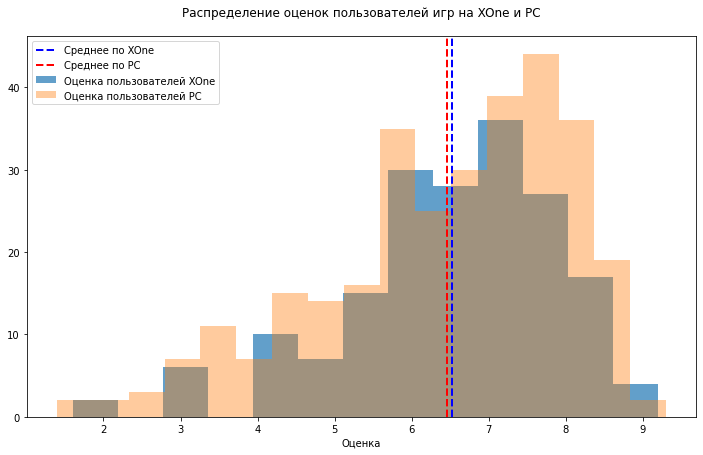

,Mean,Median,Variance,Standart deviation,Min value,Max value,5th quantile,25th quantile,75th quantile,95th quantile,IQR
Platform,,,,,,,,,,,
XOne,6.52,6.8,1.90,1.38,1.6,9.2,4.1,5.80,7.5,8.3,1.70
PC,6.45,6.8,2.59,1.61,1.4,9.3,3.3,5.55,7.7,8.5,2.15


In [47]:
mean_s = np.round(np.mean(stat_XOne['user_score']), 2)
median_s = np.round(np.median(stat_XOne['user_score']), 2)
variance_s = np.round(np.var(stat_XOne['user_score']), 2)
standart_deviation_s = np.round(np.std(stat_XOne['user_score']), 2)
min_value_s = np.round(stat_XOne['user_score'].min(), 2)
max_value_s = np.round(stat_XOne['user_score'].max(), 2)
Q0_05_s = np.round(stat_XOne['user_score'].quantile(0.05), 2)
Q1_s = np.round(stat_XOne['user_score'].quantile(0.25), 2)
Q3_s = np.round(stat_XOne['user_score'].quantile(0.75), 2)
Q0_95_s = np.round(stat_XOne['user_score'].quantile(0.95), 2)
iqr_s = np.round(Q3_s - Q1_s, 2)

mean_u = np.round(np.mean(stat_PC['user_score']), 2)
median_u = np.round(np.median(stat_PC['user_score']), 2)
variance_u = np.round(np.var(stat_PC['user_score']), 2)
standart_deviation_u = np.round(np.std(stat_PC['user_score']), 2)
min_value_u = np.round(stat_PC['user_score'].min(), 2)
max_value_u = np.round(stat_PC['user_score'].max(), 2)
Q0_05_u = np.round(stat_PC['user_score'].quantile(0.05), 2)
Q1_u = np.round(stat_PC['user_score'].quantile(0.25), 2)
Q3_u = np.round(stat_PC['user_score'].quantile(0.75), 2)
Q0_95_u = np.round(stat_PC['user_score'].quantile(0.95), 2)
iqr_u = np.round(Q3_u - Q1_u, 2)


fig, ax = plt.subplots(figsize = (12,7)) 
ax.set_title('Распределение оценок пользователей игр на XOne и PC', pad = 20)
ax.set(xlabel = "Оценка")
plt.hist(stat_XOne['user_score'], bins = int(np.sqrt(len(stat_XOne['user_score']))),  alpha = 0.7, label = 'Оценка пользователей XOne')
plt.hist(stat_PC['user_score'], bins = int(np.sqrt(len(stat_PC['user_score']))),  alpha = 0.4, label = 'Оценка пользователей PC')

plt.axvline(x=stat_XOne['user_score'].mean(),
            linewidth=2, 
            color='b', 
            linestyle='--',
            label = 'Среднее по XOne')
plt.axvline(x=stat_PC['user_score'].mean(),
            linewidth=2, 
            color='r', 
            linestyle='--',
            label = 'Среднее по PC')

leg = plt.legend()
plt.show()
total_table = pd.DataFrame({'Platform' : ['XOne', 'PC'], 
                            'Mean' : [mean_s, mean_u], 
                            'Median' : [median_s, median_u],
                            'Variance' : [variance_s, variance_u], 
                            'Standart deviation' : [standart_deviation_s, standart_deviation_u],
                            'Min value' : [min_value_s, min_value_u], 
                            'Max value' : [max_value_s, max_value_u],
                            '5th quantile' : [Q0_05_s, Q0_05_u], 
                            '25th quantile' : [Q1_s, Q1_u],
                            '75th quantile' : [Q3_s, Q3_u], 
                            '95th quantile' : [Q0_95_s, Q0_95_u],
                            'IQR' : [iqr_s, iqr_u]})
display(total_table.set_index('Platform'))

На гистограмме видна схожесть распределений и средних значений оценок пользователей XOne и PC. Проверим гипотезу о равенстве средних знаений двух выборок.

Будем ипользовать двуторонний T-тест с уровнем статиcтической значимости alpha = 0.01. Значения стандартных отклонений очень близки, но стоит сначала проверить эти распределения на равенство дисперсии для точного определения параметра т-теста equal_var.

Проверим равенство дисперсий оценки пользователей XOne и PC.
Используем Тест Левена на равенство дисперсий.

Н0 - выборки имеют одинаковые дисперсии
<br>H1 - выборка имеют разные дисперсии

In [48]:
stat, p = st.levene(stat_XOne['user_score'], stat_PC['user_score'])
alpha = 0.01
print("p = {:g}".format(p))
if p < alpha: 
    print("Отвергаем нулевую гипотезу")
else: 
    print("Не получилось отвергнуть нулевую гипотезу") 

p = 0.0192386
Не получилось отвергнуть нулевую гипотезу


Мы с уровнем статистической достоверности 0.01 подтвердили, что дисперсии распределений одинаковы и мы можем установить параметр Т-теста equal_var = True

Т.к мы будем использовать Т-тест по распределению средних из подвыборок, то проверка данных на соответствие нормальному распределению не обязательна.

Проведем Т-тест на равенство средних значений с уровнем статиcтической значимости alpha = 0.01.

H0 - Средние оценки пользователей XOne и PC равны
H1 - Средние оценки пользователей XOne и PC не равны


In [49]:
alpha = 0.01
results = st.ttest_ind(stat_XOne['user_score'], stat_PC['user_score'], equal_var = True)

print('p-значение:', results.pvalue.round(2))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else: 
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.63
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value означает, что вероятность получить случайно такое или большее различие между средними значениями распределений равно 63%, что больше порогового уровня alpha. Это не дает нам возможность отвергнуть нулевую гипотезу и значит, средние значения оценок пользователей XOne и PC равны.

#### Сравнение оценок пользователей жанров Action и Sports

Сравним рейтинги жанров Action и Sports.Построим гистограммы этих распределений.

In [50]:
stat_Action = df2.query('genre == "Action" & user_score >= 0')
stat_Sports = df2.query('genre == "Sports" & user_score >= 0')

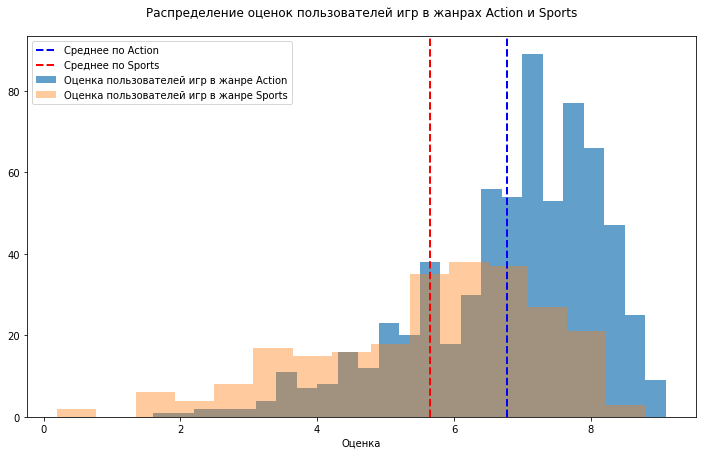

,Mean,Median,Variance,Standart deviation,Min value,Max value,5th quantile,25th quantile,75th quantile,95th quantile,IQR
Genre,,,,,,,,,,,
Action,6.78,7.1,1.80,1.34,1.6,9.1,4.1,6.1,7.8,8.45,1.7
Sports,5.66,6.0,2.87,1.69,0.2,8.8,2.7,4.4,6.9,7.87,2.5


In [51]:
mean_s = np.round(np.mean(stat_Action['user_score']), 2)
median_s = np.round(np.median(stat_Action['user_score']), 2)
variance_s = np.round(np.var(stat_Action['user_score']), 2)
standart_deviation_s = np.round(np.std(stat_Action['user_score']), 2)
min_value_s = np.round(stat_Action['user_score'].min(), 2)
max_value_s = np.round(stat_Action['user_score'].max(), 2)
Q0_05_s = np.round(stat_Action['user_score'].quantile(0.05), 2)
Q1_s = np.round(stat_Action['user_score'].quantile(0.25), 2)
Q3_s = np.round(stat_Action['user_score'].quantile(0.75), 2)
Q0_95_s = np.round(stat_Action['user_score'].quantile(0.95), 2)
iqr_s = np.round(Q3_s - Q1_s, 2)

mean_u = np.round(np.mean(stat_Sports['user_score']), 2)
median_u = np.round(np.median(stat_Sports['user_score']), 2)
variance_u = np.round(np.var(stat_Sports['user_score']), 2)
standart_deviation_u = np.round(np.std(stat_Sports['user_score']), 2)
min_value_u = np.round(stat_Sports['user_score'].min(), 2)
max_value_u = np.round(stat_Sports['user_score'].max(), 2)
Q0_05_u = np.round(stat_Sports['user_score'].quantile(0.05), 2)
Q1_u = np.round(stat_Sports['user_score'].quantile(0.25), 2)
Q3_u = np.round(stat_Sports['user_score'].quantile(0.75), 2)
Q0_95_u = np.round(stat_Sports['user_score'].quantile(0.95), 2)
iqr_u = np.round(Q3_u - Q1_u, 2)


fig, ax = plt.subplots(figsize = (12,7)) 
ax.set_title('Распределение оценок пользователей игр в жанрах Action и Sports', pad = 20)
ax.set(xlabel = "Оценка")
plt.hist(stat_Action['user_score'], bins = int(np.sqrt(len(stat_Action['user_score']))),  alpha = 0.7, label = 'Оценка пользователей игр в жанре Action')
plt.hist(stat_Sports['user_score'], bins = int(np.sqrt(len(stat_Sports['user_score']))),  alpha = 0.4, label = 'Оценка пользователей игр в жанре Sports')

plt.axvline(x=stat_Action['user_score'].mean(),
            linewidth=2, 
            color='b', 
            linestyle='--',
            label = 'Среднее по Action')
plt.axvline(x=stat_Sports['user_score'].mean(),
            linewidth=2, 
            color='r', 
            linestyle='--',
            label = 'Среднее по Sports')

leg = plt.legend()
plt.show()
total_table = pd.DataFrame({'Genre' : ['Action', 'Sports'], 
                            'Mean' : [mean_s, mean_u], 
                            'Median' : [median_s, median_u],
                            'Variance' : [variance_s, variance_u], 
                            'Standart deviation' : [standart_deviation_s, standart_deviation_u],
                            'Min value' : [min_value_s, min_value_u], 
                            'Max value' : [max_value_s, max_value_u],
                            '5th quantile' : [Q0_05_s, Q0_05_u], 
                            '25th quantile' : [Q1_s, Q1_u],
                            '75th quantile' : [Q3_s, Q3_u], 
                            '95th quantile' : [Q0_95_s, Q0_95_u],
                            'IQR' : [iqr_s, iqr_u]})
display(total_table.set_index('Genre'))

На гистограмме показаны распределения и средние значения оценок пользователей игр в жанрах Action и Sports. Проверим гипотезу о равенстве средних знаений двух выборок.

Будем ипользовать двуторонний T-тест с уровнем статиcтической значимости alpha = 0.01. Значения стандартных отклонений близки, но стоит сначала проверить эти распределения на равенство дисперсии для точного определения параметра т-теста equal_var.

Проверим равенство дисперсий оценки пользователей XOne и PC.
Используем Тест Левена на равенство дисперсий.

Н0 - выборки имеют одинаковые дисперсии
<br>H1 - выборка имеют разные дисперсии

In [52]:
stat, p = st.levene(stat_Action['user_score'], stat_Sports['user_score'])
alpha = 0.01
print("p = {:g}".format(p))
if p < alpha: 
    print("Отвергаем нулевую гипотезу")
else: 
    print("Не получилось отвергнуть нулевую гипотезу") 

p = 1.44978e-05
Отвергаем нулевую гипотезу


Мы с уровнем статистической достоверности 0.01 опровергли гипотезу, что дисперсии распределений одинаковы и поэтому мы должны установить параметр Т-теста equal_var = False

Т.к мы будем использовать Т-тест по распределению средних из подвыборок, то проверка данных на соответствие нормальному распределению не обязательна.

Проведем Т-тест на равенство средних значений с уровнем статиcтической значимости alpha = 0.01.

H0 - Средние оценки пользователей игр в жанрах Action и Sports равны
<br>H1 - Средние оценки пользователей игр в жанрах Action и Sports не равны


In [53]:
alpha = 0.01
results = st.ttest_ind(stat_Action['user_score'], stat_Sports['user_score'], equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else: 
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.774852186972399e-19
Отвергаем нулевую гипотезу


Полученное значение p-value означает, что вероятность получить случайно такое или большее различие между средними значениями распределений порядка e-19%, что значительно меньше порогового уровня alpha. Это дает нам право отвергнуть нулевую гипотезу и считать средние значения оценок пользователей игр в жанрах Action и Sports неравными друг другу.

#### Вывод

Проверка выдвинутых гипотез с уровнем достоверности 0.01 показала, что распределение оценок пользователей на двух платформах имеют одинаковые средние значения и дисперсии, т.е., грубо говоря, поведение пользователей XOne и PC схоже.
<br>В то же время, оценки пользователей игр в жанрах Action и Sports распределены не одинаково. С уровнем достоверности 0.01 мы отвергли гипотезы о равентве средних значений этих распределений и их диперсий. Посмотрев на гистограмму видно, что пользовательские оценки игр в жанре Action в целом выше, чем у игр в жанре Sports.

<div class="alert alert-block alert-success">
    

__Комментарий от ревьюера__

Отличная подготовка к проверке гипотез, тут добавить нечего. Гипотезы проверены корректно
</div>

### Общий вывод

Общий вывод
Удалось выявить закономерности, определяющие успешность игры, которые помогут спрогнозировать потенциально популярный продукт и спланировать рекламные кампании. Рассмотренные факторы по-разному влияют на продажи игр. Наиболее важные параметры связаны с популярностью игровой платформы, жанром и оценкой критиков. Оценки пользователей, наоборот, практически не влияют на продажи игр. 

Проведен временной анализ продаж по более чем 16 тысячам игр на 31 игровой платформе до 2016 года. По динамике продаж игр на самых популярных платформах определен актуальный период в 5 предшествующих лет для анализа текущей ситуации. По данным за это время наиболее перспективными платформами являются PS4, XOne. По суммарному количеству проданных копий игр наибольшее число у жанра Action, и связано это скорее всего с большим количеством выпущенных игр, т.е с популярностью самого жанра, а не с популярностью отдельных игр. К популярным жанрам можно также отнести Shooter и Sports. При этом удалось выделить группу жанров с самыми низкими показателями продаж. Это Puzzle, Strategy и Adventure.

По проведенному сравнительному анализу поведения пользователей из разных стран составлен портрет пользователя каждого региона. Наиболее активная часть аудитории соответствует следующим параметрам:


|Регион|Платформа|Жанр|ESRB рейтинг|
|:----|:----|:----|:----|
|Северная Америка|X360|Action|M (17+)|
|Европа|PS3|Action|M (17+)|
|Япония|3DS|Role-Playing|E (0+)|

В результате проверки гипотез о равенстве средних и дисперсий распределений оценок пользователей по двум платформам и двум жанрам игр выявлено, что пользователи XOne и PC ставят оценки похожим образом, а вот в оценке игр из разных жанров, пользователи чаще ставят более высокие оценки играм жанра Action, чем Sport.

В ходе анализа было обнаружено больше 40% пропущенных значений в столбцах с оценками пользователей и критиков, а также ESRB рейтингом. Стоит отследить момент потери этих данных и попробовать восполнять пропуски из других многочисленных игровых баз.